In [1]:
import pandas as pd
import numpy as np
import warnings
import math
from statsmodels.api import families
from sklearn.metrics import r2_score
import statsmodels.api as sm


from glmnet import ElasticNet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from statsmodels.formula.api import *
plt.style.use("seaborn")


In [2]:
# read in appropriate training data
train_avg = pd.read_pickle("../preprocessed_data/train_avg.pkl")

In [3]:
# read in appropriate TEST yearly green taxi files
tgreens = []

for i in range(7,13):
    num = str(i).zfill(2)
    tgreens.append(pd.read_csv(f"../raw_data/green_tripdata_2016-{num}.csv", index_col = False))
    
for i in range(1,7):
    num = str(i).zfill(2)
    tgreens.append(pd.read_csv(f"../raw_data/green_tripdata_2017-{num}.csv"))
    
tgreen = pd.concat(tgreens).reset_index()


/opt/miniconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [4]:
# read in test climate data
tclis = []
for name in ["2684313.csv", "2684315.csv", "2684316.csv", "2684317.csv"]:
    tclis.append(pd.read_csv(f"../raw_data/{name}"))
tclimate = pd.concat(tclis).reset_index()

In [5]:
# Date of each day 
tgreen["DATE"] = pd.to_datetime(tgreen["lpep_pickup_datetime"]).dt.to_period("D").astype(str)


In [6]:
# only vendor id 1 or 2 
tgreen = tgreen.loc[(tgreen["VendorID"] == 1) | (tgreen["VendorID"] == 2)]

In [7]:
# tip excluded
def tip_excluded(x):
    if x[0] == 1:
        return x[1] - x[2]
    else:
        return x[1]


tgreen["tip_excluded"] = tgreen[["payment_type", "total_amount", "tip_amount"]].apply(tip_excluded, axis = 1)

In [8]:
# only cash or cheque payments
tgreen = tgreen.loc[(tgreen["payment_type"] == 1) |(tgreen["payment_type"] == 2)]

In [9]:
# tip excluded amount created for test data
tgreen["tip_excluded"] = tgreen.loc[tgreen["tip_excluded"] > 0]["tip_excluded"]

In [10]:
# log transformation applied to tip excluded amount
tgreen["logged_tip_excluded"] = np.log(tgreen["tip_excluded"])

In [11]:
# test average respones variables creaeted
test_avg = tgreen.groupby("DATE").mean()[["logged_tip_excluded", "tip_excluded"]]

In [12]:
#Just JFK airport for weather data
tclimate = tclimate.loc[tclimate["STATION"] == "USW00094789"][["STATION", "NAME", "DATE", "PRCP", "SNOW", "TAVG"]].dropna().reset_index()


In [13]:
# Day of week
test_avg["day_of_week"] = pd.to_datetime(tclimate["DATE"]).dt.day_name().values

In [14]:
tclimate["did_rain_or_snow"] = (tclimate["PRCP"] > 0) | (tclimate["SNOW"] > 0)


In [15]:
# binary categorical rain or snow for testing
test_avg["did_rain_or_snow"] = tclimate["did_rain_or_snow"].values

In [16]:
# input test temperature average
test_avg["TAVG"] = tclimate["TAVG"].values

In [17]:
test_avg[["TAVG", "day_of_week", "did_rain_or_snow"]]

,TAVG,day_of_week,did_rain_or_snow
DATE,,,
2016-07-01,74.0,Friday,True
2016-07-02,74.0,Saturday,False
2016-07-03,75.0,Sunday,False
2016-07-04,74.0,Monday,True
2016-07-05,78.0,Tuesday,True
...,...,...,...
2017-06-26,72.0,Monday,False
2017-06-27,70.0,Tuesday,True
2017-06-28,71.0,Wednesday,False


In [18]:
# binary categoricla rain or snow created for training
train_avg["did_rain_or_snow"] = (train_avg["PRCP"].values > 0) | (train_avg["SNOW"].values > 0)

In [19]:
train_avg

,index,VendorID,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,...,tip_excluded,pay_per_mile,logged_tip_excluded,logged_trip_distance,day_of_week,TAVG,count,did_rain_or_snow,PRCP,SNOW
DATE,,,,,,,,,,,,,,,,,,,,,
2015-07-01,2.487324e+04,1.790558,1.069597,-73.936720,40.750061,-73.890170,40.722393,1.362833,2.914271,12.274466,...,13.613461,6.125161,2.450752,0.709440,Wednesday,76.0,47617,True,0.26,0.0
2015-07-02,7.543153e+04,1.794381,1.073438,-73.933437,40.752146,-73.875876,40.719508,1.369094,2.920641,12.330138,...,13.659638,6.157077,2.450688,0.705287,Thursday,77.0,49402,True,0.03,0.0
2015-07-03,1.267724e+05,1.790503,1.063725,-73.932980,40.748641,-73.893417,40.725618,1.393519,3.022949,12.086849,...,13.202562,5.736171,2.419354,0.741201,Friday,73.0,49070,False,0.00,0.0
2015-07-04,1.792135e+05,1.793643,1.059346,-73.933290,40.744903,-73.887933,40.718807,1.414186,3.119017,12.355279,...,13.489069,5.534239,2.448320,0.801224,Saturday,73.0,51629,True,0.01,0.0
2015-07-05,2.317126e+05,1.790011,1.051918,-73.931956,40.746268,-73.889934,40.722609,1.397618,3.178008,12.292839,...,13.435302,5.432097,2.445577,0.815996,Sunday,74.0,49193,False,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-26,7.341440e+05,1.795790,1.036935,-73.935665,40.741198,-73.920296,40.730605,1.382371,3.182374,12.684342,...,13.855685,5.561242,2.467341,0.812571,Sunday,73.0,49601,False,0.00,0.0
2016-06-27,8.774081e+05,1.793303,1.057277,-73.934554,40.750938,-73.907736,40.734484,1.349264,2.859970,12.109345,...,13.465098,6.234831,2.436084,0.677467,Monday,73.0,38375,True,0.09,0.0
2016-06-28,9.973584e+05,1.786945,1.064244,-73.936887,40.749839,-73.900376,40.728034,1.347965,2.799876,12.105386,...,13.446598,6.323009,2.434850,0.662139,Tuesday,72.0,35972,True,0.14,0.0


In [20]:
# fit final model
fit = glm(formula="logged_tip_excluded ~ TAVG + day_of_week + did_rain_or_snow", data = train_avg, family= families.Gaussian()).fit()

print(fit.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     logged_tip_excluded   No. Observations:                  366
Model:                             GLM   Df Residuals:                      357
Model Family:                 Gaussian   Df Model:                            8
Link Function:                identity   Scale:                      0.00027886
Method:                           IRLS   Log-Likelihood:                 983.04
Date:                 Mon, 16 Aug 2021   Deviance:                     0.099554
Time:                         00:50:19   Pearson chi2:                   0.0996
No. Iterations:                      3                                         
Covariance Type:             nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept     

In [21]:
predicted = np.exp(fit.predict())

In [22]:
# np.exp(avg["logged_tip_excluded"])

In [23]:
actual = np.exp(train_avg["logged_tip_excluded"])

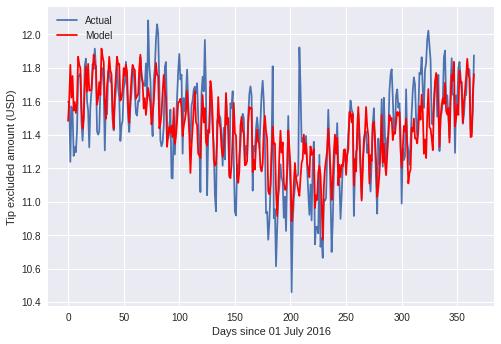

In [24]:
# visualise performance on training data
fig,ax = plt.subplots()
ax.plot(range(0,366), actual)
ax.set_ylabel("Mean of Logged Tip Excluded Amount (USD)")
ax.set_xlabel("Days since 01 July 2016")


ax.plot(range(0,366), predicted, color = "red")
ax.set_ylabel("Tip excluded amount (USD)")

plt.legend(["Actual", "Model"])
# plt.xticks(range(0,365))
plt.savefig("predicted_vs_actual.pdf")



In [25]:
test_predicted = np.exp(fit.predict(test_avg[["TAVG", "day_of_week", "did_rain_or_snow"]]))

In [26]:
test_avg["logged_tip_excluded"]

DATE
2016-07-01    2.442958
2016-07-02    2.433952
2016-07-03    2.428825
2016-07-04    2.450127
2016-07-05    2.425283
                ...   
2017-06-26    2.412153
2017-06-27    2.450945
2017-06-28    2.430469
2017-06-29    2.432277
2017-06-30    2.415541
Name: logged_tip_excluded, Length: 365, dtype: float64

In [27]:
test_real = np.exp(test_avg["logged_tip_excluded"])

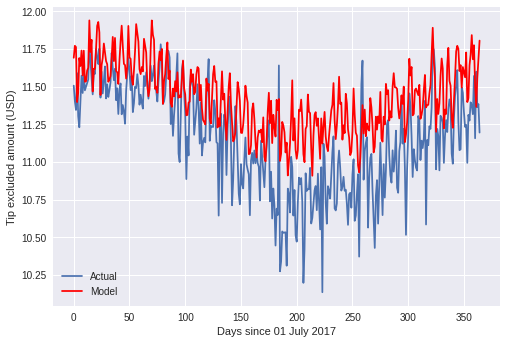

In [28]:
# visualise performance on test data
fig,ax = plt.subplots()
ax.plot(range(0,365), test_real)
ax.set_ylabel("Mean of Logged Tip Excluded Amount (USD)")
ax.set_xlabel("Days since 01 July 2017")


ax.plot(range(0,365), test_predicted, color = "red")
ax.set_ylabel("Tip excluded amount (USD)")

plt.legend(["Actual", "Model"])
# plt.xticks(range(0,365))
plt.savefig("future_predicted_vs_actual.pdf")



In [29]:
r2_score(test_real, test_predicted)

-0.04433661306552028

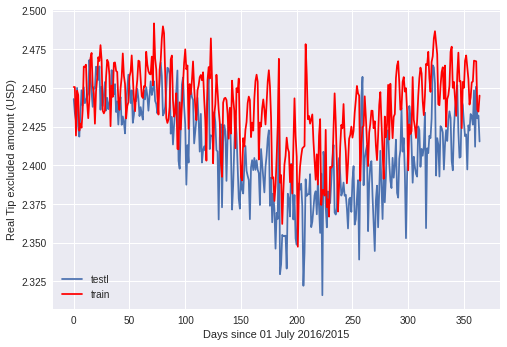

In [30]:
# visualise training vs test data to examine reason for model poor prediction
plt.style.use("seaborn")

fig,ax = plt.subplots()
ax.plot(range(0,365), test_avg["logged_tip_excluded"])
ax.set_ylabel("Mean of Logged Tip Excluded Amount (USD)")
ax.set_xlabel("Days since 01 July 2016/2015")


ax.plot(range(0,365), train_avg["logged_tip_excluded"][0:365], color = "red")
ax.set_ylabel("Real Tip excluded amount (USD)")

plt.legend(["testl", "train"])
# plt.xticks(range(0,365))
plt.savefig("real_tip_excluded_train_vs_test.pdf")

